In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [4]:
%matplotlib notebook

In [5]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


In [6]:
#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)

#Binning: 

#MAGNITUDE:
num_mag_bins = 4
mag_bin_perc = np.array([0,25,50,75,100])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


In [5]:
# #Pre-processing: 

# #Trial boundaries:
# trial_start = np.where((df['bin']==-10.0))[0]
# trial_stop = np.where((df['trial_stop']==1))[0]
# trial_bound = np.vstack((trial_start,trial_stop)).T
# num_trials = trial_bound.shape[0]

# #-----------------------------------------------------------------------------------------------
# #Time till end of trial: 
# df['bin_end'] = 0
# df['prog'] = 0

# for bnd in trial_bound:
#     bin_data = df['bin'][bnd[0]:bnd[1]+1]
#     last_bin = bin_data.iloc[-1]
#     bin_end = last_bin-bin_data
#     prog = bin_data/last_bin
#     #ASSIGN:
#     df['bin_end'][bnd[0]:bnd[1]+1] = bin_end
#     df['prog'][bnd[0]:bnd[1]+1] = prog
    
# #-----------------------------------------------------------------------------------------------    
# #Cond Trial number
# for task in range(num_tasks):
#     for target in range(num_targets):
#         cond_sel = (df['task']==task) & (df['target']==target)
#         trial_start = (df['bin']==0) & cond_sel 
#         trial_stop = (df['bin_end']==0) & cond_sel
#         trial_bnd = np.vstack((np.where(trial_start)[0], np.where(trial_stop)[0]))
#         for i,bnd in enumerate(trial_bnd.T):
#             print(i, bnd)
#             df.loc[bnd[0]:bnd[1], 'trial_cond'] = i
    
# #-----------------------------------------------------------------------------------------------    
# #Polar coordinates: 
# # 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# # 1) Convert stuff to polar
# df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
# df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
# df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
# df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# # 2) Center @ target angle: 
# d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
# for d in d_list:
#     data = df[d]
#     zeros = np.zeros(data.shape)
#     t_angle = target_angle[df['target'].astype(int)]
#     df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# # 3) distance to target
# error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
# df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
# df['x_error'] = error.loc[:,'kin_px']
# df['y_error'] = error.loc[:,'kin_py']    

# #-----------------------------------------------------------------------------------------------
# #BINNING: 
# #1) magnitude bins: 
# num_mag_bins = 4
# mag_bin_perc = np.array([0,25,50,75,100])
# mag_data = df['u_v_mag']
# #mag_data = df['u_v_mag'][df['bin']>=0] - we didn't do this, because we want to be able to bin all data, negative bins
# mag_bin = np.percentile(mag_data, mag_bin_perc)
# mag_bin_edges = np.vstack((mag_bin[0:-1], mag_bin[1:]))
# mag_bin_c = mag_bin_edges.mean(axis=0)

# #2) angle bins: 
# num_angle_bins = 8
# T0_angle = -3*(2*np.pi)/8
# angle_bin_c = np.linspace(T0_angle, T0_angle+np.pi*2, num=num_angle_bins+1, endpoint=True)
# # angle_bin_c[angle_bin_c > np.pi] = angle_bin_c[angle_bin_c > np.pi] - 2*np.pi #center at angle 0 instead of 180
# angle_bin = angle_bin_c-np.pi*2/16.0
# # angle_bin[angle_bin < -np.pi] = angle_bin[angle_bin < -np.pi] + 2*np.pi
# angle_bin_edges = np.vstack((angle_bin[0:-1], angle_bin[1:]))

# #center angles for binning: 
# angle_center_for_binning = (angle_bin[-1]+angle_bin[0])/2.0
# print('angle_center:', angle_center_for_binning*180/np.pi)

# angle_vars = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
# for d in angle_vars:
#     df[d] = bmi_b.center_angle_v2(np.array(df[d]), angle_center_for_binning)
# print('min centered angle:', np.min(df['u_v_angle'])*180/np.pi)
# print('max centered angle:', np.max(df['u_v_angle'])*180/np.pi)

# #BIN DATA: 
# bin_dic = {}
# bin_dic[0] = mag_bin_edges
# bin_dic[1] = angle_bin_edges

# data2bin = np.array(df[['u_v_mag','u_v_angle']])
# bin_r, hist_r = bmi_b.bin_vec_data(data2bin, bin_dic)
# df['u_v_mag_bin']=bin_r[:,0]
# df['u_v_angle_bin']=bin_r[:,1]

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0, array([7706, 7733], dtype=int64))
(1, array([7744, 7771], dtype=int64))
(2, array([7782, 7815], dtype=int64))
(3, array([7826, 7855], dtype=int64))
(4, array([7866, 7900], dtype=int64))
(5, array([7911, 7945], dtype=int64))
(6, array([7956, 7995], dtype=int64))
(7, array([8006, 8040], dtype=int64))
(8, array([8051, 8077], dtype=int64))
(9, array([8088, 8122], dtype=int64))
(10, array([8133, 8184], dtype=int64))
(11, array([8195, 8225], dtype=int64))
(12, array([8236, 8266], dtype=int64))
(13, array([14141, 14171], dtype=int64))
(14, array([14182, 14209], dtype=int64))
(15, array([14220, 14249], dtype=int64))
(16, array([14260, 14286], dtype=int64))
(17, array([14297, 14324], dtype=int64))
(18, array([14335, 14363], dtype=int64))
(19, array([14374, 14401], dtype=int64))
(20, array([14412, 14459], dtype=int64))
(21, array([14470, 14514], dtype=int64))
(22, array([14525, 14555], dtype=int64))
(23, array([14566, 14593], dtype=int64))
(24, array([14604, 14642], dtype=int64))
(25, array(

In [8]:
def plot_command_bin(angle_linewidth=3): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color, angle_linewidth)

### Visualize Binning: 

<IPython.core.display.Javascript object>


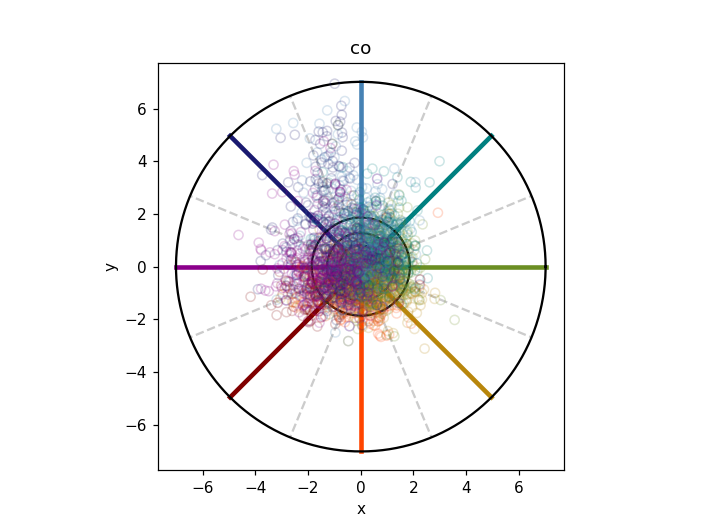

<IPython.core.display.Javascript object>


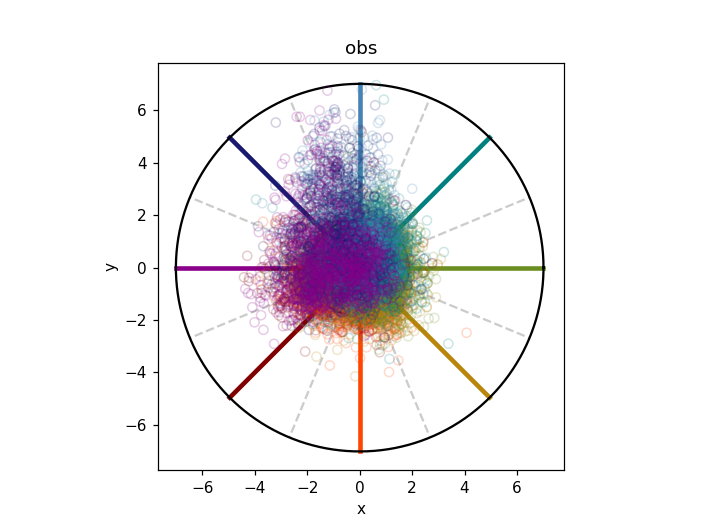

Text(0,0.5,'y')

In [12]:
for task in range(num_tasks):
    plt.figure()
    plt.title(task_list[task])    
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges, target_color)
    for target in range(num_targets):
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            sel = task_sel & target_sel
            
            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.2,facecolors='none', edgecolors=target_color[target],zorder=1000)

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
#Plot the mean command per movement

In [15]:
x.shape

(1364L,)

<IPython.core.display.Javascript object>


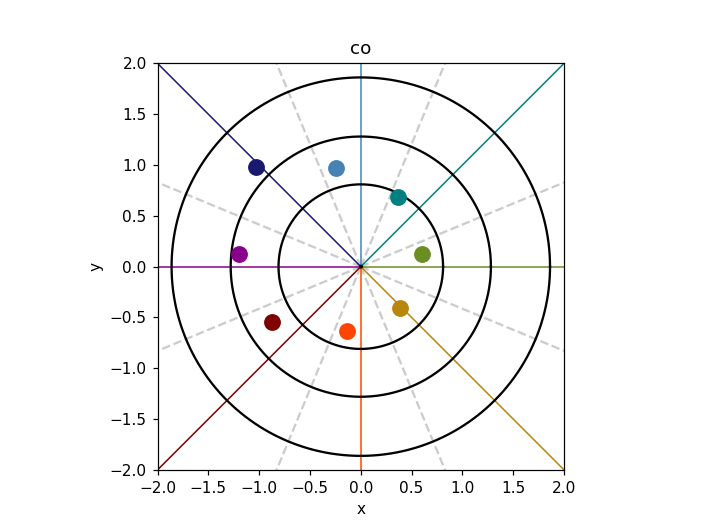

<IPython.core.display.Javascript object>


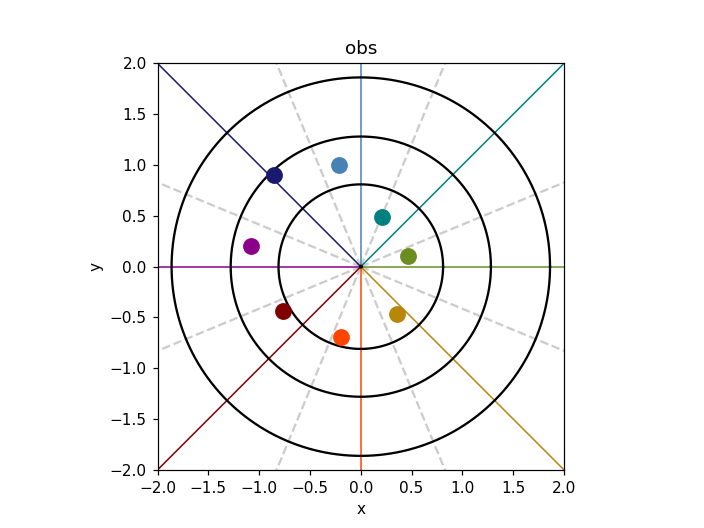

In [22]:
for task in range(num_tasks):
    plt.figure()
    plt.title(task_list[task])    
    plot_command_bin(angle_linewidth=1)
    for target in range(num_targets):
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            sel = task_sel & target_sel
            
            x = df['u_vx'][sel].mean()
            y = df['u_vy'][sel].mean()
            plt.scatter(x, y,s=100, alpha=1,color=target_color[target],zorder=1000)

    plt.xlim([-2,2])
    plt.ylim([-2,2])
#     plt.axis('square')
    plt.xlabel('x')
    plt.ylabel('y')


<IPython.core.display.Javascript object>


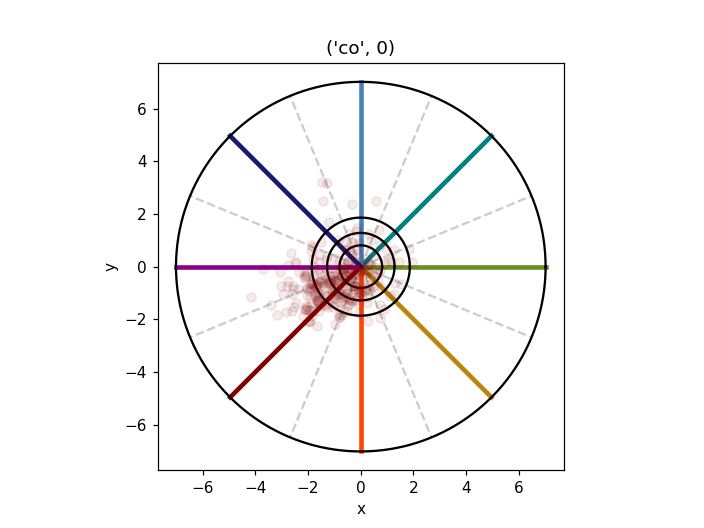

<IPython.core.display.Javascript object>


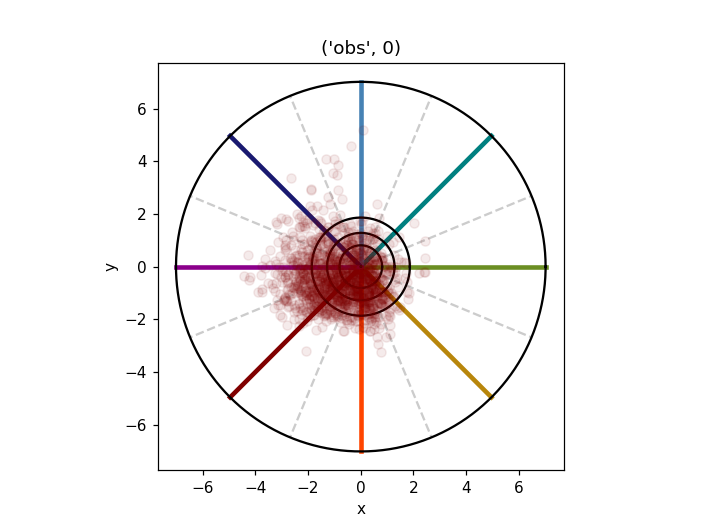

Text(0,0.5,'y')

In [14]:
for target in [0]:#range(num_targets): #[0]
    for task in range(num_tasks):
        plt.figure()
        plt.title((task_list[task], target))    
        plot_command_bin()        
        
        task_sel = (df['task'] == task)
        target_sel = (df['target'] == target)
        sel = task_sel & target_sel

        x = df['u_vx'][sel]
        y = df['u_vy'][sel]
        plt.scatter(x, y,alpha=0.08,color=target_color[target])

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
#co movement uses lower spread of commands than does obstacle movement

<IPython.core.display.Javascript object>


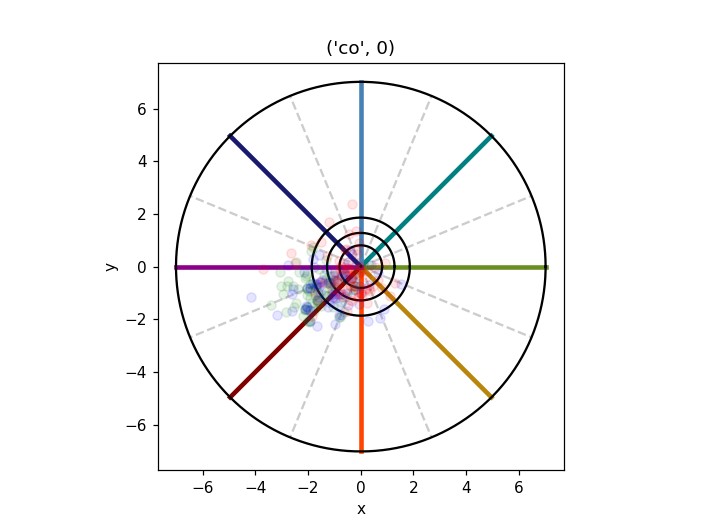

c:\anaconda3\envs\py2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


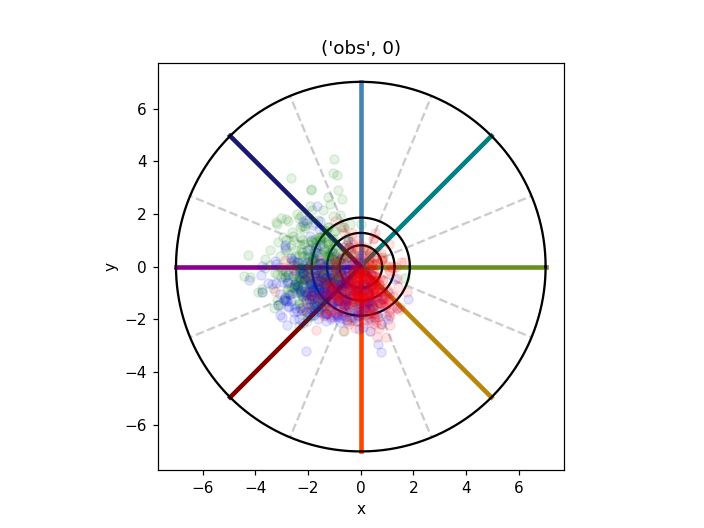

<IPython.core.display.Javascript object>


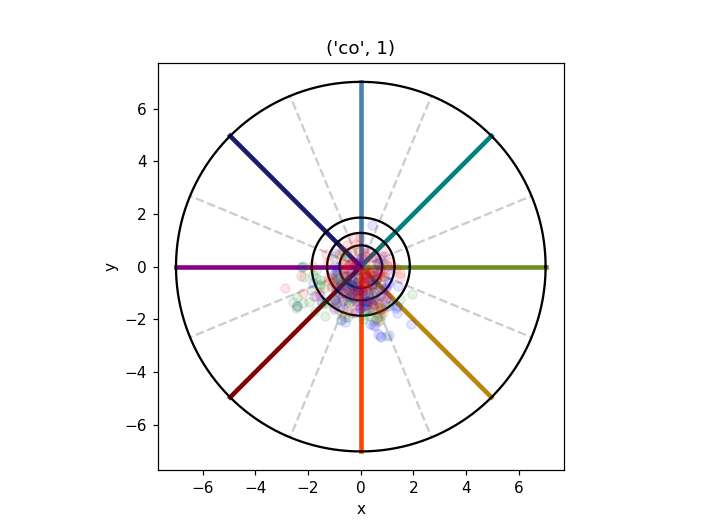

<IPython.core.display.Javascript object>


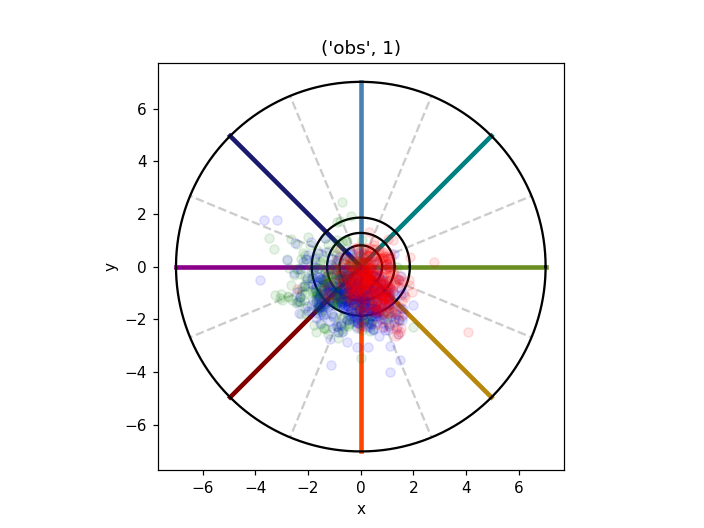

<IPython.core.display.Javascript object>


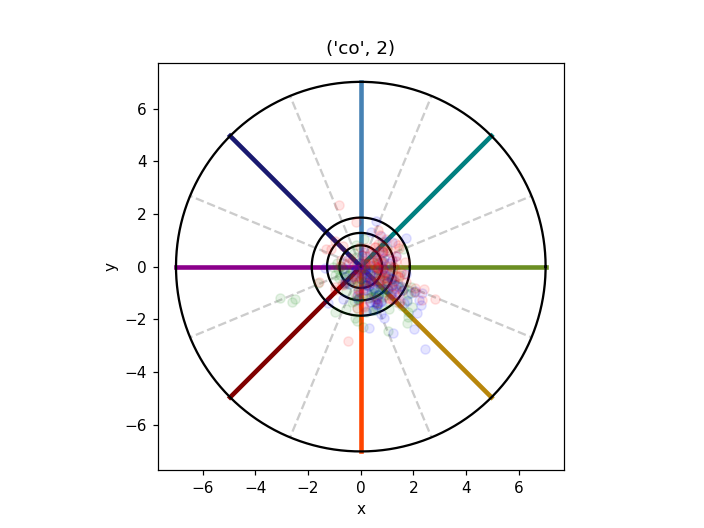

<IPython.core.display.Javascript object>


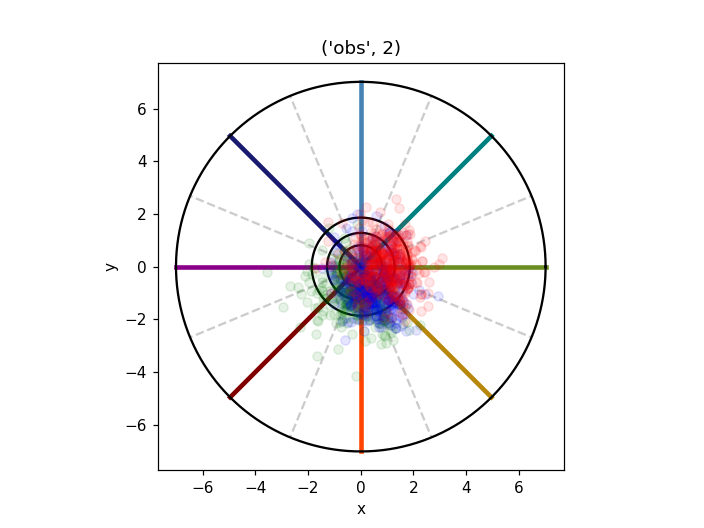

<IPython.core.display.Javascript object>


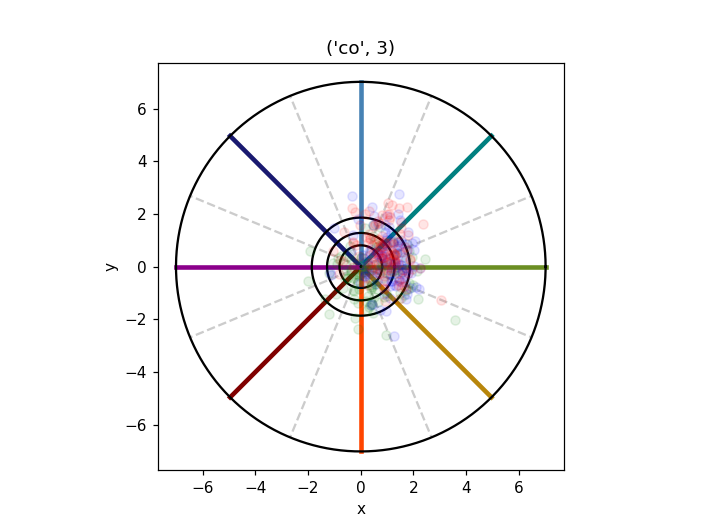

<IPython.core.display.Javascript object>


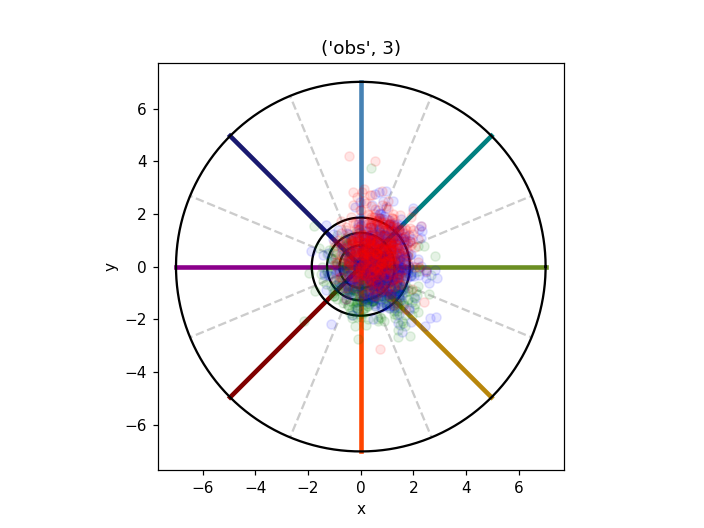

<IPython.core.display.Javascript object>


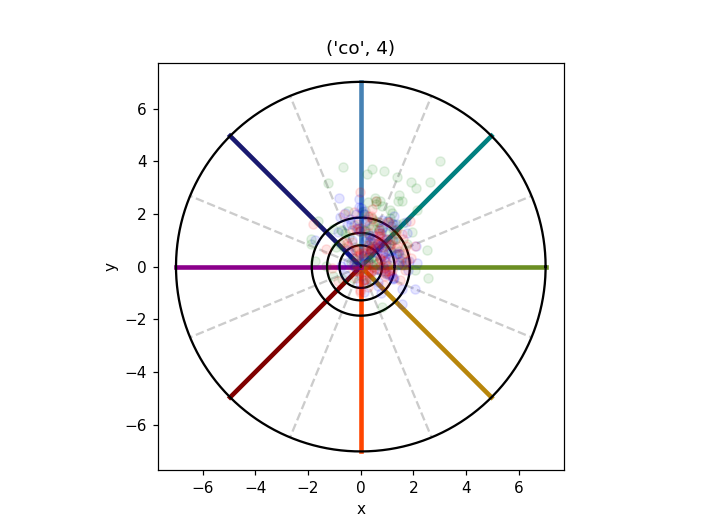

<IPython.core.display.Javascript object>


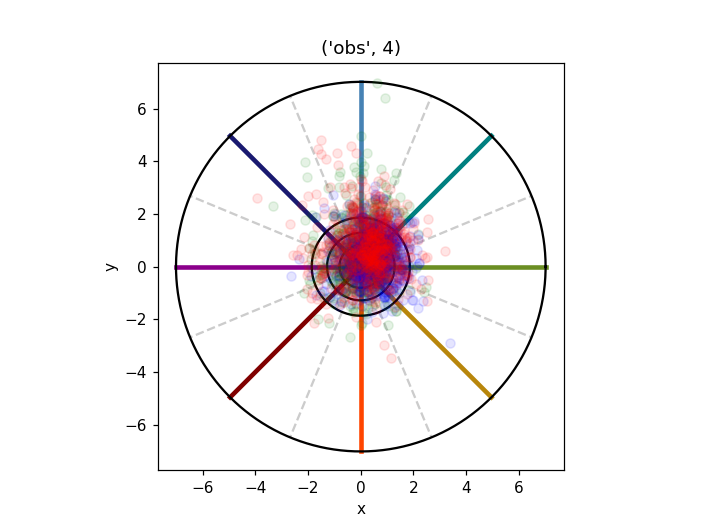

<IPython.core.display.Javascript object>


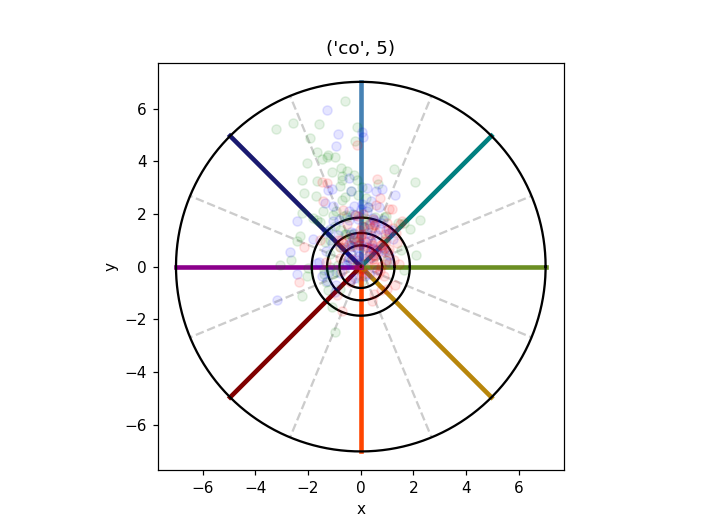

<IPython.core.display.Javascript object>


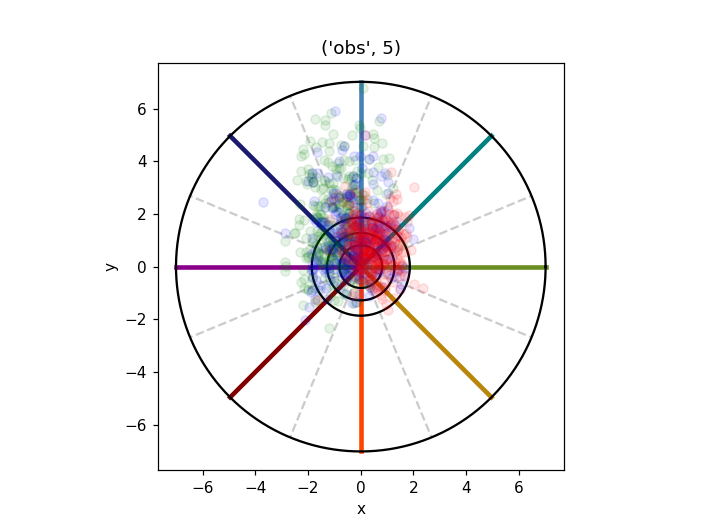

<IPython.core.display.Javascript object>


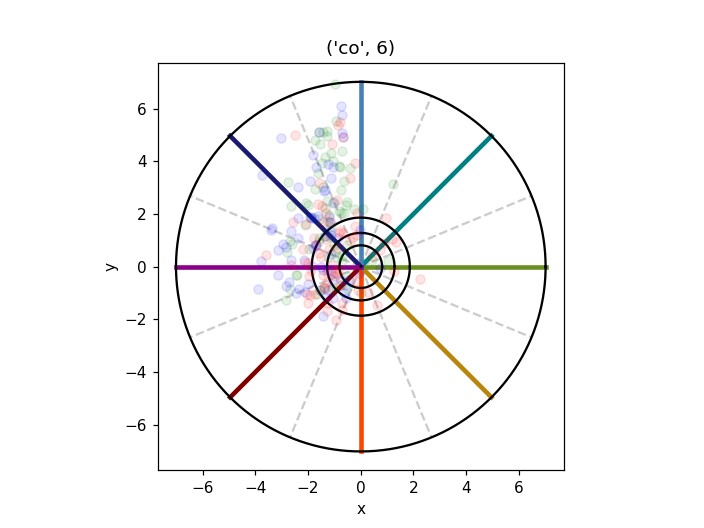

<IPython.core.display.Javascript object>


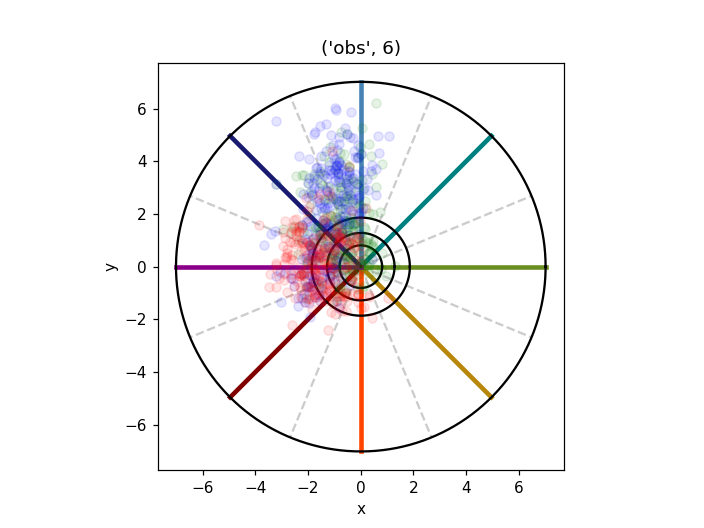

<IPython.core.display.Javascript object>


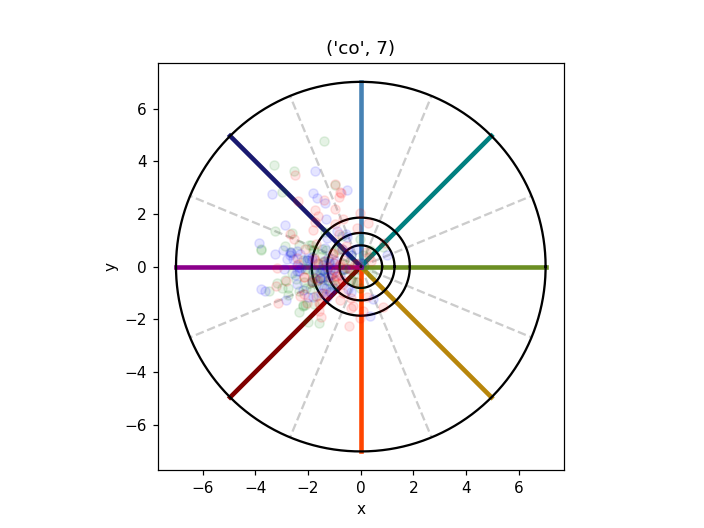

<IPython.core.display.Javascript object>


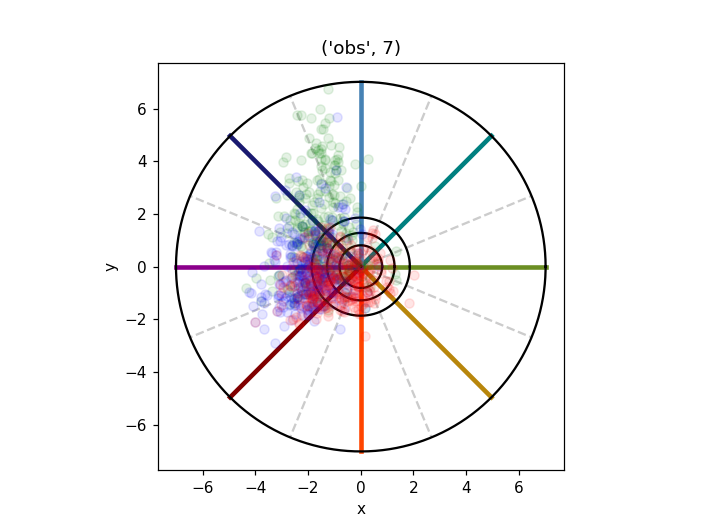

Text(0,0.5,'y')

In [10]:
#early middle late scatter plot
num_phases = 3
phases = np.linspace(0,1,num_phases+1)
trial_phase = np.array([phases[0:-1],phases[1:]])

phase_color = ['g', 'b', 'r'] #maroon
for target in range(num_targets): #[0]
#     plt.subplot(2,3,)
    for task in range(num_tasks):
        plt.figure()
        plot_command_bin()   
        plt.title((task_list[task], target))    
        for phase in range(num_phases):
#             plt.title((task_list[task], target, 'phase: ', phase))    
                 
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
            sel = task_sel & target_sel & phase_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=phase_color[phase])
# phase_color[phase])#target_color[target])
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

### Command-Locked PSTH: 

In [9]:
#NOTE: This takes some time...
min_trials = 5
win = [-5,5] #[0, 1]
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy', 'kin_px', 'kin_py']
task_pairs = [(0,0), (0,1), (1,1)]
if win[0] <= 0:
    zero_lag_idx = -win[0]

psth_c_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth_center_at_lag(psth_c_dic, psth_var, zero_lag_idx, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)

# diff_df = bmi_b.calc_command_psth_diff(task_target_bin_dic, task_pairs, zero_lag_idx, min_trials, num_targets, num_mag_bins, num_angle_bins)

(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1, 0, 4, 4)
(0, 1, 0, 5, 8)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 5)
(0, 1, 1, 0, 18)
(0, 1, 1, 1, 23)
(0, 1, 1, 2, 14)
(0, 1, 1, 3, 4)
(0, 1, 1, 4, 1)
(0, 1, 1, 5, 3)
(0, 1, 1, 6, 3)
(0, 1, 1, 7, 8)
(0, 1, 2, 0, 9)
(0, 1, 2, 1, 31)
(0, 1, 2, 2, 17)
(0, 1, 2, 3, 1)
(0, 1, 2, 4, 0)
(0, 1, 2, 5, 1)
(0, 1, 2, 6, 0)
(0, 1, 2, 7, 3)
(0, 1, 3, 0, 11)
(0, 1, 3, 1, 17)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 0)
(0, 1, 3,

(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


<IPython.core.display.Javascript object>


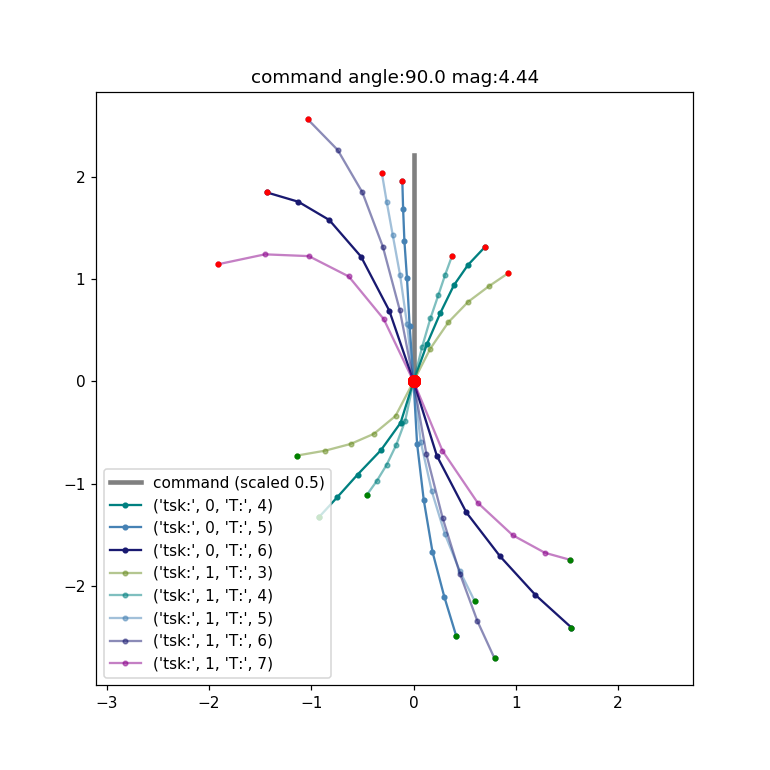

(0, 4, 20)
(0, 5, 35)
(0, 6, 20)
(1, 3, 35)
(1, 4, 103)
(1, 5, 152)
(1, 6, 146)
(1, 7, 40)


In [26]:
min_trials_plot = 15 #10
# mag_bin = 1
angle_bin = 5
sc = 0.5

#PLOT COMMAND: 

for mag_bin in [3]:
    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc
    
    #-----------------------------------------------------------------------------------------------------------------
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.5, linewidth=3, label='command (scaled ' + str(sc)+')')
    task_alpha = [1, 0.5]
    for task in range(0,num_tasks):
        for target in range(0,num_targets):
            num_trials = psth_c_dic[task, target, mag_bin, angle_bin, 'num']
            if num_trials >= min_trials_plot:
                print(task, target, num_trials)
                data = psth_c_dic[task, target, mag_bin, angle_bin, 'psth']
                plt.plot(data.loc['kin_px'], data.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
                plt.plot(data.loc['kin_px', 0], data.loc['kin_py', 0], '.-', color='r', markersize=15)   
                plt.plot(data.loc['kin_px', win[1]], data.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
                plt.plot(data.loc['kin_px', win[0]], data.loc['kin_py', win[0]], '.-', color='g')  
    plt.axis('equal')
#     ax.set_aspect('equal')
    plt.legend()
    plt.title('command angle:'+str(round(pa*180/np.pi,2)) + ' mag:' + str(round(pm,2)))
    

In [25]:
trial_bnd

array([], shape=(2L, 0L), dtype=int64)

In [31]:
# len(np.where(cond_sel)[0])
np.where(cond_sel)[0]

array([1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028,
       2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039,
       2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050,
       2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061,
       2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072,
       2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083,
       2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094,
       2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105,
       2106, 2107, 2108, 2109, 2110, 2111, 2112, 21

In [35]:
df.loc[1963,:]

n_0                 1.000000
n_1                 0.000000
n_2                 0.000000
n_3                 0.000000
n_4                 2.000000
n_5                 3.000000
n_6                 2.000000
n_7                 0.000000
n_8                 0.000000
n_9                 0.000000
n_10                0.000000
n_11                1.000000
n_12                0.000000
n_13                0.000000
n_14                2.000000
n_15                0.000000
n_16                2.000000
n_17                0.000000
n_18                0.000000
n_19                0.000000
n_20                0.000000
n_21                3.000000
n_22                1.000000
n_23                0.000000
n_24                0.000000
n_25                1.000000
n_26                1.000000
n_27                0.000000
n_28                1.000000
n_29                1.000000
                    ...     
kin_vy             -1.487337
task                0.000000
tc               4377.000000
target        

In [26]:
num_trials

35

In [38]:
psth_c_dic[task, target, mag_bin, angle_bin, 'num']

35

<IPython.core.display.Javascript object>


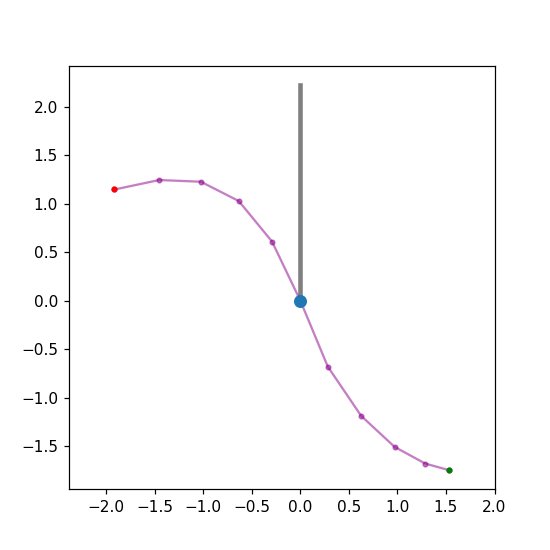

<IPython.core.display.Javascript object>


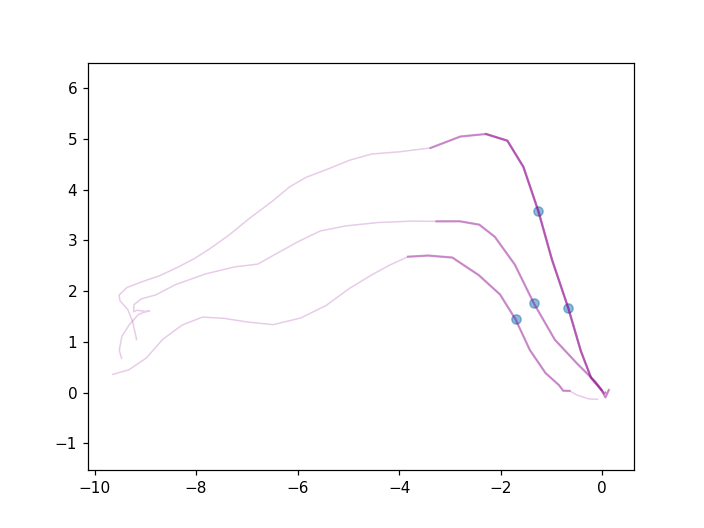

[7706 7733]
[7866 7900]
[7911 7945]


In [48]:
#c-l psth: command-locked psth
#For each c-l psth, I want to plot individual trajectories and show the commands 
mag_bin = 3
ang_bin = 5
task =1 #1 #0
target = 7 #7 #5
num_trials = psth_c_dic[task, target, mag_bin, angle_bin, 'num']

#PLOT:
#CHOOSE WHICH TRIALS:
#----------------------------------------------------------------------------------------------
which_trials = np.array([0,4, 5]) #2, 4
#mag_bin=3, ang_bin=6:
#good: 
#4,5, 6,10

#----------------------------------------------------------------------------------------------

cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']



#PLOT PSTH
data = psth_c_dic[task, target, mag_bin, angle_bin, 'psth']
plt.figure(figsize=(5,5))

plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.5, linewidth=3, label='command (scaled ' + str(sc)+')')

plt.plot(data.loc['kin_px'], data.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
plt.plot(data.loc['kin_px', 0], data.loc['kin_py', 0], '.-', color=cycle[0], markersize=15)   
plt.plot(data.loc['kin_px', win[1]], data.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
plt.plot(data.loc['kin_px', win[0]], data.loc['kin_py', win[0]], '.-', color='g')  
plt.axis('equal')

#PLOT TRIALS: 
cond_sel = (df['task']==task) & (df['target']==target)

#Only select certain trials:
which_trial_sel = (df['trial_cond']==which_trials[0])
for i,t in enumerate(which_trials):
    which_trial_sel = which_trial_sel | (df['trial_cond']==which_trials[i])
    
trial_start = (df['bin']==0) & cond_sel & which_trial_sel
trial_stop = (df['bin_end']==0) & cond_sel & which_trial_sel
trial_bnd = np.vstack((np.where(trial_start)[0], np.where(trial_stop)[0]))
# plt.figure(figsize=(5,5))
plt.figure()
for i,bnd in enumerate(trial_bnd.T):
    
    print(bnd)
    x = df['kin_px'][bnd[0]:bnd[1]+1]
    y = df['kin_py'][bnd[0]:bnd[1]+1]
    color = target_color[target]
    plt.plot(x,y,'-',linewidth=1, color=color, alpha=0.2)

#PLOT COMMAND-LETS:     
command_sel = (df['u_v_mag_bin']==mag_bin)&(df['u_v_angle_bin']==angle_bin)
intra_trial_sel = (df['bin']>=5)&(df['bin_end']>=5)
command_trial_sel = command_sel&cond_sel&intra_trial_sel*which_trial_sel
plt.scatter(df.loc[command_trial_sel, 'kin_px'], df.loc[command_trial_sel, 'kin_py'], color=cycle[0], alpha=0.5) 
plt.axis('equal')

c_win = np.array([-5, 5])
ca = np.where(command_trial_sel)[0]
for c in ca:
    w = c_win+c
    x = df['kin_px'][w[0]:w[1]+1]
    y = df['kin_py'][w[0]:w[1]+1]
    plt.plot(x,y,'-',color=color,alpha=0.35)
    


In [25]:
#PLOT INDIVIDUAL TRIALS: 

plot_bool = False

if plot_bool:
    save_bool = False
    plt_prefix = 'trials'
    plt_ext = ['.png', '.eps']

    plot={}
    plot['size'] = (7,7)
    plot['xlim'] = (-12.5,12.5)
    plot['ylim'] = (-12.5,12.5)

    plot_obs_subset = False
    plot_obs_small_trials = False
    plot_obs_big_trials = True


    plot_target = True
    plot_obs_small = True
    plot_obs_big = True

    for task_str in task_list:
        task = task2idx[task_str]
        plt.figure(figsize=plot['size'])
        for target in range(num_targets):
            if task_str == 'co' or (task_str == 'obs' and plot_obs_subset == False): 
                sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
            elif task_str == 'obs' and plot_obs_small_trials:
                sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_small)
            elif task_str == 'obs' and plot_obs_big_trials:
                sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target) & (df['obs_size']==obs_big)

            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

        if plot_obs_small:
            bmi_util.plot_obstacles(obs_pos, target_color, obs_small*np.ones(num_targets))
        if plot_obs_big:
            bmi_util.plot_obstacles(obs_pos, target_color, obs_big*np.ones(num_targets))
        if plot_target: 
            bmi_util.plot_targets(target_pos, target_color, target_r_eff[task]*np.ones(num_targets))  

        plt.axis('square')
        plt.title(task_str)
    #     plt.xlim(plot['xlim'])
    #     plt.ylim(plot['ylim'])
        plt.show()

        if save_bool: 
            plt_name = plt_prefix + '_' + task_str
            for ext in plt_ext:
                plt.savefig(os.path.join(save_dir, plt_name+ext))    
    

### Check the mean differences

In [51]:
#NOTE: This takes some time...
n_list = ['n_'+str(i) for i in np.arange(num_neurons)]

min_trials = 5
win = [-5,5] 
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy', 'kin_px', 'kin_py']
psth_var.extend(n_list)
print(psth_var)
task_pairs = [(0,0), (0,1), (1,1)]
if win[0] <= 0:
    zero_lag_idx = -win[0]

#GET TRIALS:    
task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)

#GET PSTH:
bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)

['u_vx', 'u_vy', 'kin_px', 'kin_py', 'n_0', 'n_1', 'n_2', 'n_3', 'n_4', 'n_5', 'n_6', 'n_7', 'n_8', 'n_9', 'n_10', 'n_11', 'n_12', 'n_13', 'n_14', 'n_15', 'n_16', 'n_17', 'n_18', 'n_19', 'n_20', 'n_21', 'n_22', 'n_23', 'n_24', 'n_25', 'n_26', 'n_27', 'n_28', 'n_29', 'n_30', 'n_31', 'n_32', 'n_33', 'n_34', 'n_35', 'n_36', 'n_37', 'n_38', 'n_39', 'n_40', 'n_41', 'n_42', 'n_43']
(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1, 0, 4, 4)
(0, 1, 0, 5, 8)
(0, 1

(1, 6, 3, 5, 146)
(1, 6, 3, 6, 90)
(1, 6, 3, 7, 60)
(1, 7, 0, 0, 11)
(1, 7, 0, 1, 8)
(1, 7, 0, 2, 3)
(1, 7, 0, 3, 2)
(1, 7, 0, 4, 2)
(1, 7, 0, 5, 3)
(1, 7, 0, 6, 4)
(1, 7, 0, 7, 3)
(1, 7, 1, 0, 19)
(1, 7, 1, 1, 5)
(1, 7, 1, 2, 2)
(1, 7, 1, 3, 0)
(1, 7, 1, 4, 0)
(1, 7, 1, 5, 3)
(1, 7, 1, 6, 8)
(1, 7, 1, 7, 22)
(1, 7, 2, 0, 34)
(1, 7, 2, 1, 9)
(1, 7, 2, 2, 0)
(1, 7, 2, 3, 0)
(1, 7, 2, 4, 1)
(1, 7, 2, 5, 4)
(1, 7, 2, 6, 17)
(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


In [41]:
task_target_bin_dic[0,0,0,0,'psth']

<xarray.DataArray (var: 48, time: 11)>
array([[-1.269932, -1.241932, -1.649923, ..., -0.971476, -0.553832, -0.682746],
       [-0.724789, -1.09507 , -1.053345, ..., -0.806701, -0.528424, -0.807107],
       [-3.235165, -3.528743, -3.844156, ..., -5.098894, -5.24857 , -5.381551],
       ...,
       [ 4.625   ,  4.125   ,  6.75    , ...,  5.25    ,  4.625   ,  5.25    ],
       [ 0.875   ,  1.      ,  1.625   , ...,  1.75    ,  2.875   ,  1.875   ],
       [ 0.75    ,  2.      ,  0.75    , ...,  0.625   ,  0.875   ,  0.625   ]])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy' 'kin_px' 'kin_py' ... 'n_41' 'n_42' 'n_43'
  * time     (time) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5

In [21]:
#COMPUTE THE N, B DIFFERENCES: 

In [42]:
columns = ['n_diff_norm', 'b_diff_norm', 'b_diff_norm_lag0',
            'mag_bin', 'angle_bin', 
            'task0', 'target0', 'num_trials0', 'u_vx0', 'u_vy0',
            'task1', 'target1', 'num_trials1', 'u_vx1', 'u_vy1']
num_col = len(columns)
nan_df = pd.DataFrame(np.ones((1,num_col))*np.nan, columns=columns)
df_list = []
task_pairs = [(0,0), (0,1), (1,1)]
vec_diff_dic = {}

for task0, task1 in task_pairs:
    for t0 in range(num_targets):
        if task0 == task1:
            t1_set = range(t0, num_targets)
        else:
            t1_set = range(0,num_targets)
        for t1 in t1_set:
            print(task0, t0, task1, t1)
            for bm in range(num_mag_bins):
                for ba in range(num_angle_bins):
                    num_trials0 = task_target_bin_dic[task0,t0,bm,ba,'num']
                    d0_valid = num_trials0 >= min_trials
                    num_trials1 = task_target_bin_dic[task1,t1,bm,ba,'num']
                    d1_valid = num_trials1 >= min_trials                        
                    if d0_valid&d1_valid:
                        #Check if same movement: 
                        if (task0==task1)&(t0==t1):
                            #if same movement, compare psth's on different splits of data: 
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth',0]
                            d1 = task_target_bin_dic[task0,t0,bm,ba,'psth',1]
                        else:
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth']
                            d1 = task_target_bin_dic[task1,t1,bm,ba,'psth']
                        
                        #ASSIGN:
                        vec_diff_dic[bm, ba, task0, t0, task1, t1] = d0-d1
                        df_i = copy.copy(nan_df)                        
                        
                        #neural diff is over lag 0: 
                        df_i['n_diff_norm'] = np.linalg.norm(d0.loc[n_list,0]-d1.loc[n_list,0])
                        
                        #behavior diff is over all lags: 
                        df_i['b_diff_norm'] = np.linalg.norm(d0.loc[['u_vx', 'u_vy'],:]-d1.loc[['u_vx', 'u_vy'],:])
                        
                        #behavior diff is over all lags: 
                        df_i['b_diff_norm_lag0'] = np.linalg.norm(d0.loc[['u_vx', 'u_vy'],0]-d1.loc[['u_vx', 'u_vy'],0])                        
                        
                        df_i['mag_bin'] = bm
                        df_i['angle_bin'] = ba                 
                        
                        df_i['task0'] = task0
                        df_i['target0'] = t0
                        df_i['num_trials0'] = num_trials0
                        df_i['u_vx0'] = float(d0.loc['u_vx',0])
                        df_i['u_vy0'] = float(d0.loc['u_vy',0])

                        df_i['task1'] = task1
                        df_i['target1'] = t1
                        df_i['num_trials1'] = num_trials1
                        df_i['u_vx1'] = float(d1.loc['u_vx',0])
                        df_i['u_vy1'] = float(d1.loc['u_vy',0])
                        
                        #APPEND:
                        df_list.append(df_i)

diff_df = pd.concat(df_list, ignore_index=True)

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 0, 2)
(0, 0, 0, 3)
(0, 0, 0, 4)
(0, 0, 0, 5)
(0, 0, 0, 6)
(0, 0, 0, 7)
(0, 1, 0, 1)
(0, 1, 0, 2)
(0, 1, 0, 3)
(0, 1, 0, 4)
(0, 1, 0, 5)
(0, 1, 0, 6)
(0, 1, 0, 7)
(0, 2, 0, 2)
(0, 2, 0, 3)
(0, 2, 0, 4)
(0, 2, 0, 5)
(0, 2, 0, 6)
(0, 2, 0, 7)
(0, 3, 0, 3)
(0, 3, 0, 4)
(0, 3, 0, 5)
(0, 3, 0, 6)
(0, 3, 0, 7)
(0, 4, 0, 4)
(0, 4, 0, 5)
(0, 4, 0, 6)
(0, 4, 0, 7)
(0, 5, 0, 5)
(0, 5, 0, 6)
(0, 5, 0, 7)
(0, 6, 0, 6)
(0, 6, 0, 7)
(0, 7, 0, 7)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 1, 2)
(0, 0, 1, 3)
(0, 0, 1, 4)
(0, 0, 1, 5)
(0, 0, 1, 6)
(0, 0, 1, 7)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 1, 2)
(0, 1, 1, 3)
(0, 1, 1, 4)
(0, 1, 1, 5)
(0, 1, 1, 6)
(0, 1, 1, 7)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 1, 2)
(0, 2, 1, 3)
(0, 2, 1, 4)
(0, 2, 1, 5)
(0, 2, 1, 6)
(0, 2, 1, 7)
(0, 3, 1, 0)
(0, 3, 1, 1)
(0, 3, 1, 2)
(0, 3, 1, 3)
(0, 3, 1, 4)
(0, 3, 1, 5)
(0, 3, 1, 6)
(0, 3, 1, 7)
(0, 4, 1, 0)
(0, 4, 1, 1)
(0, 4, 1, 2)
(0, 4, 1, 3)
(0, 4, 1, 4)
(0, 4, 1, 5)
(0, 4, 1, 6)
(0, 4, 1, 7)
(0, 5, 1, 0)

In [43]:
diff_df.head()

n_diff_norm  b_diff_norm  b_diff_norm_lag0  mag_bin  angle_bin  task0  \
0     3.913119     2.800938          0.198908        0          0      0   
1     6.847546     3.359155          0.280203        0          7      0   
2     3.883298     1.618778          0.214184        1          0      0   
3     4.221308     4.012619          0.205263        1          1      0   
4     3.607947     2.025776          0.102644        2          0      0   

   target0  num_trials0     u_vx0     u_vy0  task1  target1  num_trials1  \
0        0            8 -0.269101 -0.343435      0        0            8   
1        0            5 -0.648608 -0.210816      0        0            5   
2        0           10 -0.706526 -0.680340      0        0           10   
3        0            7 -0.106467 -0.999461      0        0            7   
4        0           19 -1.122533 -1.039983      0        0           19   

      u_vx1     u_vy1  
0 -0.465050 -0.377612  
1 -0.609807  0.066688  
2 -0.919711 -0.659677  
3  0.066333 -0.888677  
4 -1.025117 -1.007641

In [50]:
#Pool all differences: 
plt.figure(figsize=(5,5))
x = diff_df.loc[:,'n_diff_norm']
y = diff_df.loc[:,'b_diff_norm']
plt.scatter(x,y,alpha=0.25)
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')
r,p = scipy.stats.pearsonr(x,y)
plt.title('pooling all (command, condition pairs) correlation: ' + str(round(r,2)))


<IPython.core.display.Javascript object>

NameError: name 'diff_df' is not defined

<IPython.core.display.Javascript object>


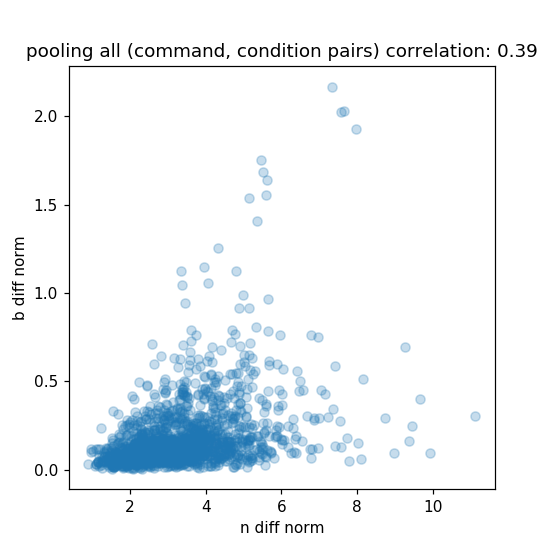

Text(0.5,1,'pooling all (command, condition pairs) correlation: 0.39')

In [45]:
#Check lag0:
plt.figure(figsize=(5,5))
x = diff_df.loc[:,'n_diff_norm']
y = diff_df.loc[:,'b_diff_norm_lag0']
plt.scatter(x,y,alpha=0.25)
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')
r,p = scipy.stats.pearsonr(x,y)
plt.title('pooling all (command, condition pairs) correlation: ' + str(round(r,2)))


In [ ]:
#TODO: compare: within move, within co, within obs, across task, across move: 
#Check: if the segment is just one lag behind and ahead vs 5 lags behind and ahead like I have now... 

In [46]:
#accumulate the differences: 
min_trials_analyze = 15
max_mag=3

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin']<=max_mag)

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'n_diff'] = diff_df.loc[sel,'n_diff_norm']
    move_sel_dic[move, 'b_diff'] = diff_df.loc[sel,'b_diff_norm']
    move_sel_dic[move, 'b_diff_lag0'] = diff_df.loc[sel,'b_diff_norm_lag0']
    
    

In [49]:
# move = 'within_move'
move_plot = ['within_move', 'within_task', 'across_task']
move_plot_color = ['b', 'g', 'r']
plt.figure(figsize=(5,5))
r_list = []
for i,move in enumerate(move_plot):
    x = move_sel_dic[move, 'n_diff']
    y = move_sel_dic[move, 'b_diff_lag0']
    r,p = scipy.stats.pearsonr(x,y)
    r_list.append(r)
    plt.scatter(x,y,color=move_plot_color[i],alpha=0.25,label=move + ' ' + str(round(r,2)))
    plt.axis('equal')
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')
plt.legend()

# title_str = ''
# for i,move in enumerate(move_plot):
#     title_str += move + ' corr:' + str(round(r_list[i],2))
# plt.title(title_str)

<IPython.core.display.Javascript object>

NameError: name 'move_sel_dic' is not defined

<IPython.core.display.Javascript object>


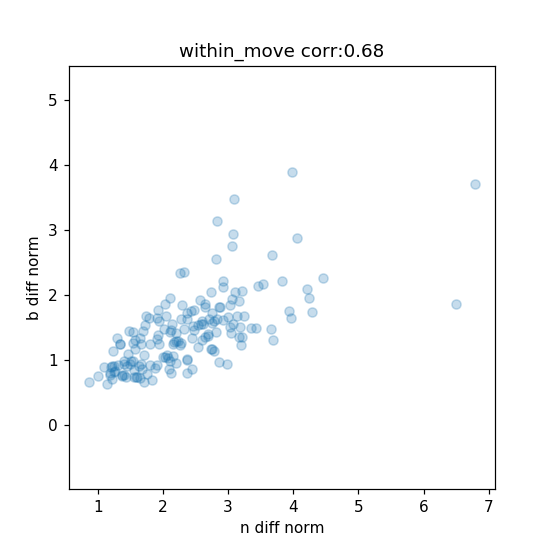

<IPython.core.display.Javascript object>


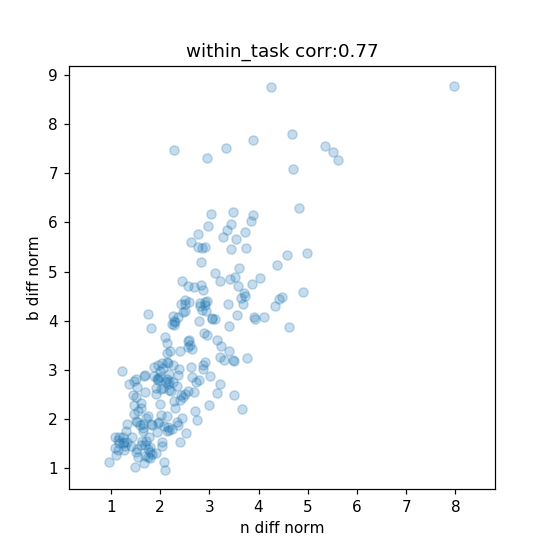

<IPython.core.display.Javascript object>


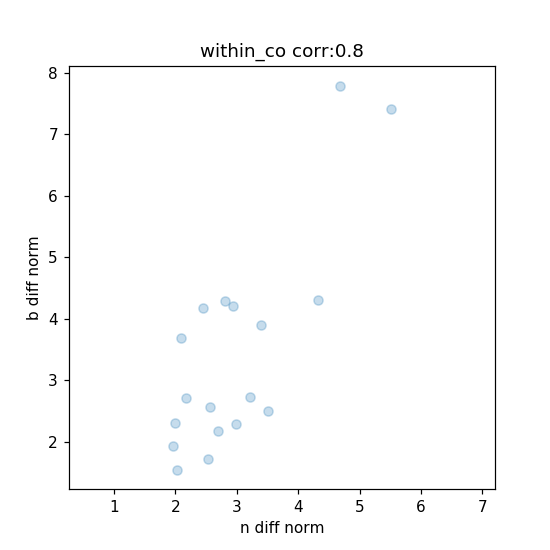

<IPython.core.display.Javascript object>


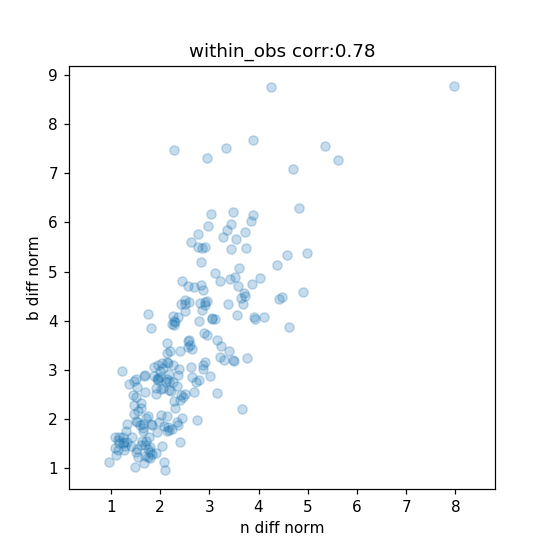

<IPython.core.display.Javascript object>


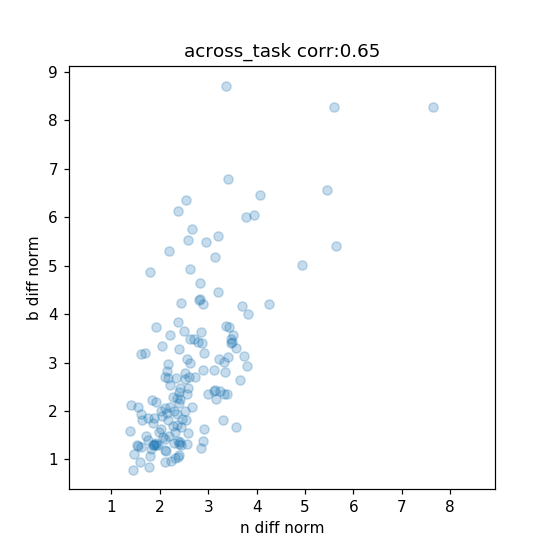

<IPython.core.display.Javascript object>


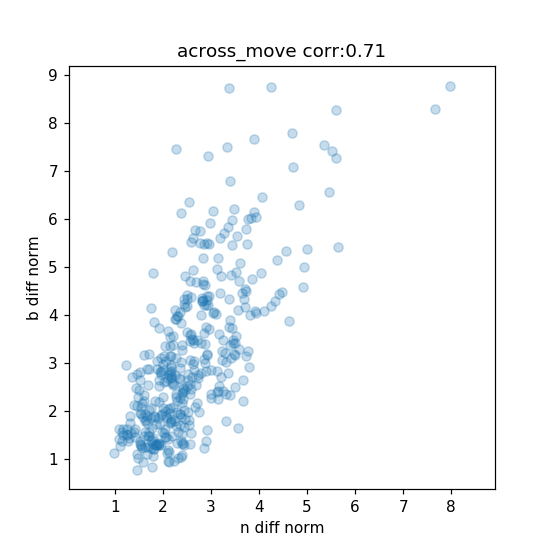

In [47]:
# move = 'within_move'
for move in move_list:
    x = move_sel_dic[move, 'n_diff']
    y = move_sel_dic[move, 'b_diff']
    r,p = scipy.stats.pearsonr(x,y)
    plt.figure(figsize=(5,5))
    plt.scatter(x,y,alpha=0.25)
    plt.axis('equal')
    plt.title(move + ' corr:' + str(round(r,2)))
    plt.xlabel('n diff norm')
    plt.ylabel('b diff norm')


In [ ]:
#Now choose a specific condition: 

28

<IPython.core.display.Javascript object>


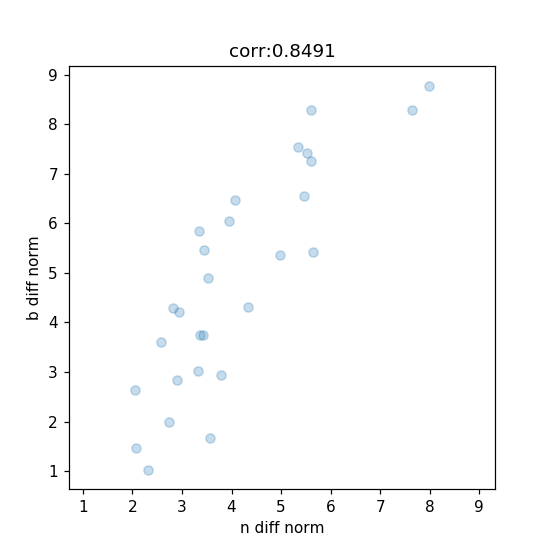

28


In [171]:
mag_bin = 3
angle_bin = 5
min_trials_analyze = 15

num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
angle_sel = (diff_df['angle_bin']==angle_bin)
mag_sel = (diff_df['mag_bin']==mag_bin)
command_sel = angle_sel&mag_sel

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &command_sel

sel = move_sel_dic['across_move', 'sel']&sel_universal

x = diff_df.loc[sel,'n_diff_norm']
y = diff_df.loc[sel,'b_diff_norm'] #b_diff_lag0
r,p = scipy.stats.pearsonr(x,y)

plt.figure(figsize=(5,5))
plt.scatter(x,y,alpha=0.25)
plt.axis('equal')
plt.title('corr:' + str(round(r,4)))
plt.xlabel('n diff norm')
plt.ylabel('b diff norm')

num_comparisons = len(np.where(sel)[0])
print(num_comparisons)

sel_ex = sel

In [177]:
diff_df[sel]

n_diff_norm  b_diff_norm  b_diff_norm_lag0  mag_bin  angle_bin  task0  \
181      2.931653     4.208610          0.432494        3          5      0   
182      5.514300     7.419328          1.683440        3          5      0   
198      4.329379     4.302745          1.254695        3          5      0   
607      3.563806     1.662450          0.403464        3          5      0   
619      2.062912     1.469428          0.127457        3          5      0   
631      2.811541     4.293935          0.640543        3          5      0   
634      4.060522     6.462052          1.055829        3          5      0   
636      5.600391     8.277502          1.552105        3          5      0   
670      5.640524     5.415254          0.783492        3          5      0   
682      3.426296     3.743060          0.499042        3          5      0   
696      2.323077     1.024416          0.210074        3          5      0   
704      3.794427     2.929954          0.628087        3          5      0   
711      3.940862     6.047526          1.147324        3          5      0   
728      7.651027     8.285025          2.029423        3          5      0   
732      5.458608     6.554338          1.752543        3          5      0   
738      3.363781     3.752962          1.044656        3          5      0   
743      3.319804     3.017449          0.627611        3          5      0   
749      2.895579     2.846954          0.338761        3          5      0   
1251     2.744965     1.993108          0.292486        3          5      1   
1276     4.987679     5.368042          0.991056        3          5      1   
1285     5.351292     7.547173          1.407620        3          5      1   
1296     7.976355     8.777149          1.929405        3          5      1   
1354     2.581332     3.601841          0.708801        3          5      1   
1365     3.351411     5.836509          1.126886        3          5      1   
1379     5.607249     7.265883          1.640304        3          5      1   
1418     2.056406     2.627954          0.418100        3          5      1   
1430     3.437046     5.451785          0.945342        3          5      1   
1451     3.520589     4.894112          0.554175        3          5      1   

      target0  num_trials0     u_vx0     u_vy0  task1  target1  num_trials1  \
181         4           20  0.012104  2.571975      0        5           35   
182         4           20  0.012104  2.571975      0        6           20   
198         5           35 -0.157883  2.969662      0        6           20   
607         4           20  0.012104  2.571975      1        3           35   
619         4           20  0.012104  2.571975      1        4          103   
631         4           20  0.012104  2.571975      1        5          152   
634         4           20  0.012104  2.571975      1        6          146   
636         4           20  0.012104  2.571975      1        7           40   
670         5           35 -0.157883  2.969662      1        3           35   
682         5           35 -0.157883  2.969662      1        4          103   
696         5           35 -0.157883  2.969662      1        5          152   
704         5           35 -0.157883  2.969662      1        6          146   
711         5           35 -0.157883  2.969662      1        7           40   
728         6           20 -0.820828  4.034915      1        3           35   
732         6           20 -0.820828  4.034915      1        4          103   
738         6           20 -0.820828  4.034915      1        5          152   
743         6           20 -0.820828  4.034915      1        6          146   
749         6           20 -0.820828  4.034915      1        7           40   
1251        3           35  0.374684  2.395004      1        4          103   
1276        3           35  0.374684  2.395004      1        5          152   
1285        3           35  0.374684  2.395004      1  

<IPython.core.display.Javascript object>


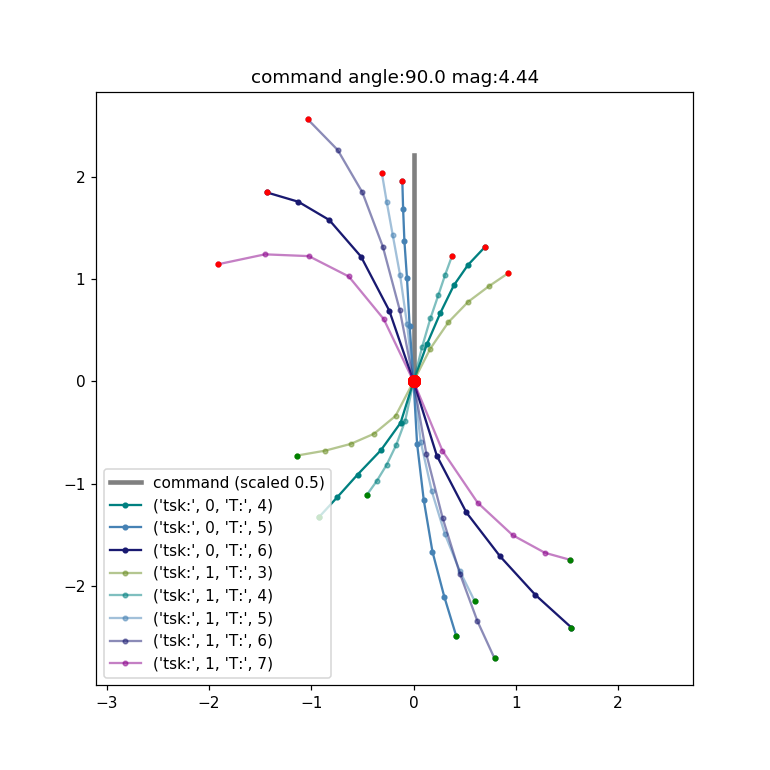

(0, 4, 20)
(0, 5, 35)
(0, 6, 20)
(1, 3, 35)
(1, 4, 103)
(1, 5, 152)
(1, 6, 146)
(1, 7, 40)


In [146]:
#Plot the trajectories compared: 
min_trials_plot = 15 #10
mag_bin_plot = 3
angle_bin = 5
sc = 0.5

#PLOT COMMAND: 

for mag_bin in [mag_bin_plot]:
    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc
    
    #-----------------------------------------------------------------------------------------------------------------
    plt.figure(figsize=(7,7))
    ax = plt.gca()
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.5, linewidth=3, label='command (scaled ' + str(sc)+')')
    task_alpha = [1, 0.5]
    for task in range(0,num_tasks):
        for target in range(0,num_targets):
            num_trials = psth_c_dic[task, target, mag_bin, angle_bin, 'num']
            if num_trials >= min_trials_plot:
                print(task, target, num_trials)
                data = psth_c_dic[task, target, mag_bin, angle_bin, 'psth']
                plt.plot(data.loc['kin_px'], data.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
                plt.plot(data.loc['kin_px', 0], data.loc['kin_py', 0], '.-', color='r', markersize=15)   
                plt.plot(data.loc['kin_px', win[1]], data.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
                plt.plot(data.loc['kin_px', win[0]], data.loc['kin_py', win[0]], '.-', color='g')  
    plt.axis('equal')
#     ax.set_aspect('equal')
    plt.legend()
    plt.title('command angle:'+str(round(pa*180/np.pi,2)) + ' mag:' + str(round(pm,2)))
    

In [196]:
ex_df

n_diff_norm  b_diff_norm  b_diff_norm_lag0  mag_bin  angle_bin  task0  \
181      2.931653     4.208610          0.432494        3          5      0   
182      5.514300     7.419328          1.683440        3          5      0   
198      4.329379     4.302745          1.254695        3          5      0   
607      3.563806     1.662450          0.403464        3          5      0   
619      2.062912     1.469428          0.127457        3          5      0   
631      2.811541     4.293935          0.640543        3          5      0   
634      4.060522     6.462052          1.055829        3          5      0   
636      5.600391     8.277502          1.552105        3          5      0   
670      5.640524     5.415254          0.783492        3          5      0   
682      3.426296     3.743060          0.499042        3          5      0   
696      2.323077     1.024416          0.210074        3          5      0   
704      3.794427     2.929954          0.628087        3          5      0   
711      3.940862     6.047526          1.147324        3          5      0   
728      7.651027     8.285025          2.029423        3          5      0   
732      5.458608     6.554338          1.752543        3          5      0   
738      3.363781     3.752962          1.044656        3          5      0   
743      3.319804     3.017449          0.627611        3          5      0   
749      2.895579     2.846954          0.338761        3          5      0   
1251     2.744965     1.993108          0.292486        3          5      1   
1276     4.987679     5.368042          0.991056        3          5      1   
1285     5.351292     7.547173          1.407620        3          5      1   
1296     7.976355     8.777149          1.929405        3          5      1   
1354     2.581332     3.601841          0.708801        3          5      1   
1365     3.351411     5.836509          1.126886        3          5      1   
1379     5.607249     7.265883          1.640304        3          5      1   
1418     2.056406     2.627954          0.418100        3          5      1   
1430     3.437046     5.451785          0.945342        3          5      1   
1451     3.520589     4.894112          0.554175        3          5      1   

      target0  num_trials0     u_vx0     u_vy0  task1  target1  num_trials1  \
181         4           20  0.012104  2.571975      0        5           35   
182         4           20  0.012104  2.571975      0        6           20   
198         5           35 -0.157883  2.969662      0        6           20   
607         4           20  0.012104  2.571975      1        3           35   
619         4           20  0.012104  2.571975      1        4          103   
631         4           20  0.012104  2.571975      1        5          152   
634         4           20  0.012104  2.571975      1        6          146   
636         4           20  0.012104  2.571975      1        7           40   
670         5           35 -0.157883  2.969662      1        3           35   
682         5           35 -0.157883  2.969662      1        4          103   
696         5           35 -0.157883  2.969662      1        5          152   
704         5           35 -0.157883  2.969662      1        6          146   
711         5           35 -0.157883  2.969662      1        7           40   
728         6           20 -0.820828  4.034915      1        3           35   
732         6           20 -0.820828  4.034915      1        4          103   
738         6           20 -0.820828  4.034915      1        5          152   
743         6           20 -0.820828  4.034915      1        6          146   
749         6           20 -0.820828  4.034915      1        7           40   
1251        3           35  0.374684  2.395004      1        4          103   
1276        3           35  0.374684  2.395004      1        5          152   
1285        3           35  0.374684  2.395004      1  

In [203]:
cond_ex = []
for i in np.arange(ex_df.shape[0]):
    row = ex_df.iloc[i]
    cond_tuple = (row['task0'], row['target0'])
    if cond_tuple not in cond_ex: 
        cond_ex.append(cond_tuple)
        
    cond_tuple = (row['task1'], row['target1'])
    if cond_tuple not in cond_ex: 
        cond_ex.append(cond_tuple)
        
print(cond_ex)
num_cond_ex = len(cond_ex)
print('number of conditions:', num_cond_ex)

[(0.0, 4.0), (0.0, 5.0), (0.0, 6.0), (1.0, 3.0), (1.0, 4.0), (1.0, 5.0), (1.0, 6.0), (1.0, 7.0)]
('number of conditions:', 8)


In [209]:
cond_ex

[(0.0, 4.0),
 (0.0, 5.0),
 (0.0, 6.0),
 (1.0, 3.0),
 (1.0, 4.0),
 (1.0, 5.0),
 (1.0, 6.0),
 (1.0, 7.0)]

In [211]:
#Make an xarray of num_neurons x num_timepoints:
nan_mat = np.ones((num_neurons, num_cond_ex))*np.nan
da = xr.DataArray(nan_mat, coords={'var':n_list, 'cond':range(num_cond_ex)}, dims=['var','cond'])
bm = 3
ba = 5

for i,cond in enumerate(cond_ex): 
    task0 = cond[0]
    t0 = cond[1]
    da[:,i] = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]
    

<xarray.DataArray (var: 44, cond: 8)>
array([[-0.444017, -0.044017, -0.244017, ...,  0.148088,  0.213517,  0.455983],
       [-0.142839, -0.014267,  0.207161, ...,  0.06374 , -0.03188 , -0.042839],
       [-0.008518, -0.008518, -0.008518, ...,  0.011219,  0.005181,  0.016482],
       ...,
       [-0.176325,  1.730818,  0.823675, ...,  0.186833, -0.785229,  2.098675],
       [-0.156812,  0.436045, -0.056812, ...,  0.098451, -0.342428, -0.331812],
       [-0.287674, -0.073388,  0.362326, ..., -0.020569,  0.07397 , -0.062674]])
Coordinates:
  * var      (var) |S4 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'
  * cond     (cond) int32 0 1 2 3 4 5 6 7

In [219]:
da.mean(axis=1).repeat((1,num_cond_ex)).shape

AttributeError: 'DataArray' object has no attribute 'repeat'

<IPython.core.display.Javascript object>


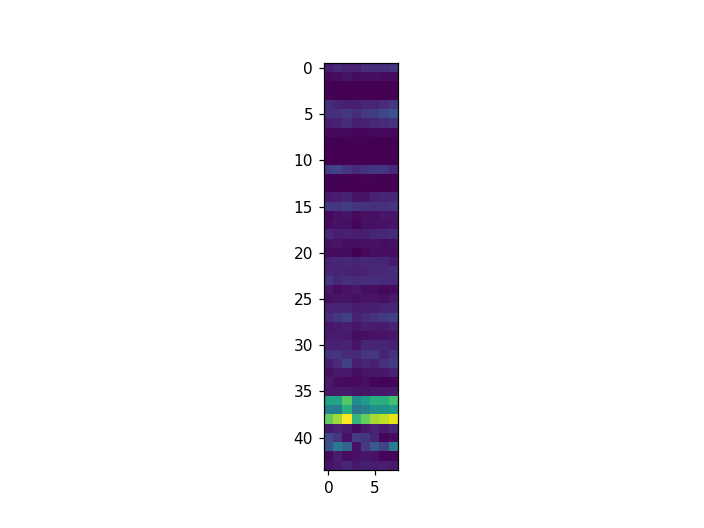

<IPython.core.display.Javascript object>


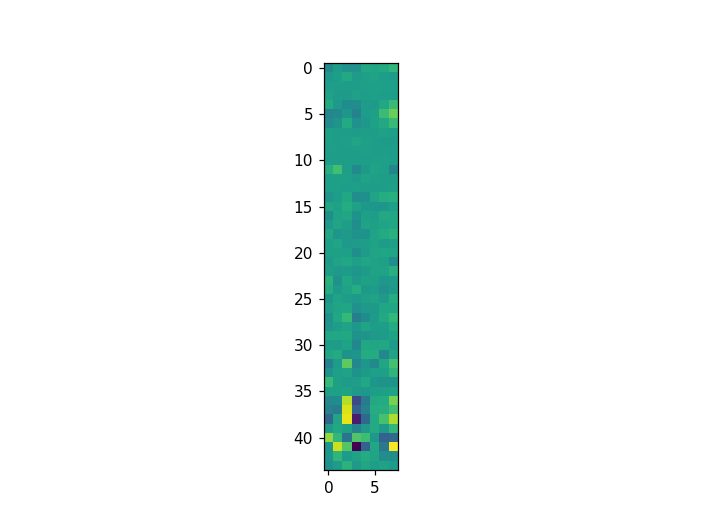

In [231]:
plt.figure()
plt.imshow(da)

#subtract the mean: 
da_c = da-np.array(da.mean(axis=1)).reshape((-1,1)).repeat(8, axis=1)
plt.figure()
plt.imshow(da_c)

In [198]:
task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]

<xarray.DataArray (var: 44)>
array([1.352518e+00, 5.827338e-01, 7.194245e-03, 2.877698e-02, 1.769784e+00,
       3.172662e+00, 1.669065e+00, 4.100719e-01, 1.438849e-02, 0.000000e+00,
       0.000000e+00, 1.884892e+00, 2.158273e-02, 1.438849e-02, 1.388489e+00,
       2.237410e+00, 6.618705e-01, 9.496403e-01, 1.287770e+00, 7.266187e-01,
       4.964029e-01, 1.705036e+00, 1.733813e+00, 1.892086e+00, 6.330935e-01,
       6.618705e-01, 1.589928e+00, 2.402878e+00, 1.079137e+00, 6.474820e-01,
       1.553957e+00, 1.618705e+00, 2.661871e+00, 1.251799e+00, 9.280576e-01,
       1.863309e+00, 2.014388e+00, 1.589928e+00, 2.446043e+00, 2.503597e+00,
       5.035971e-02, 9.014388e+00, 5.035971e-01, 8.633094e-01])
Coordinates:
  * var      (var) |S13 'n_0' 'n_1' 'n_2' 'n_3' ... 'n_40' 'n_41' 'n_42' 'n_43'
    time     int32 0

In [ ]:
                            d0 = task_target_bin_dic[task0,t0,bm,ba,'psth']
                            d1 = task_target_bin_dic[task1,t1,bm,ba,'psth']
                        
                        #ASSIGN:
                        vec_diff_dic[bm, ba, task0, t0, task1, t1] = d0-d1
                        df_i = copy.copy(nan_df)                        
                        
                        #neural diff is over lag 0: 
                        df_i['n_diff_norm'] = np.linalg.norm(d0.loc[n_list,0]-d1.loc[n_list,0])

In [170]:
#For A condition
task0 = 0
t0 = 5
bm = 3
ba = 5

u_true = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[['u_vx', 'u_vy'],0]
n = task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[n_list,0]
d=bmi_util.decompose_decoder(decoder['F'], decoder['K'])
u_test = np.dot(d['K_d']['v'], n)
vi = np.array([3,5])
print(u_test[vi])
print(u_true)
print('diff:', np.array(u_test[vi]-u_true))


F_hat close to F
K_hat close to K
[0.01210382 2.57197472]
<xarray.DataArray (var: 2)>
array([0.012104, 2.571975])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy'
    time     int32 0
('diff:', array([1.00613962e-16, 0.00000000e+00]))


In [165]:
task_target_bin_dic[task0,t0,bm,ba,'psth'].loc[['u_vx', 'u_vy'],0]

<xarray.DataArray (var: 2)>
array([-0.157883,  2.969662])
Coordinates:
  * var      (var) |S13 'u_vx' 'u_vy'
    time     int32 0

In [154]:
decoder.keys()

['A', 'C', 'F', 'K', 'Q', 'W']

In [150]:
decoder['K'].shape

(7L, 44L)

In [155]:
d=bmi_util.decompose_decoder(decoder['F'], decoder['K'])

F_hat close to F
K_hat close to K


In [159]:
d['K_d']['v'].shape

(7L, 44L)

In [ ]:
#FOR REFERENCE: 
#accumulate the differences: 
min_trials_analyze = 15
max_mag=3

#sel: 
num_trials0_sel = (diff_df['num_trials0']>=min_trials_analyze) #5
num_trials1_sel = (diff_df['num_trials1']>=min_trials_analyze) #5
mag_sel = (diff_df['mag_bin']<=max_mag)

sel_universal = \
    num_trials0_sel\
    &num_trials1_sel\
    &mag_sel

move_sel_dic = {}
move_list = ['within_move', 'within_task', 'within_co', 'within_obs', 'across_task', 'across_move']
move_sel_dic['within_move', 'sel'] = (diff_df['target0']==diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_task', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])
move_sel_dic['within_co', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==0)
move_sel_dic['within_obs', 'sel'] = (diff_df['target0']!=diff_df['target1'])&(diff_df['task0']==diff_df['task1'])&(diff_df['task0']==1)
move_sel_dic['across_task', 'sel'] = (diff_df['task0']!=diff_df['task1'])
move_sel_dic['across_move', 'sel'] = (diff_df['task0']!=diff_df['task1'])|(diff_df['target0']!=diff_df['target1'])

for move in move_list: 
    sel = sel_universal\
    &move_sel_dic[move,'sel']
    move_sel_dic[move, 'n_diff'] = diff_df.loc[sel,'n_diff_norm']
    move_sel_dic[move, 'b_diff'] = diff_df.loc[sel,'b_diff_norm']
    move_sel_dic[move, 'b_diff_lag0'] = diff_df.loc[sel,'b_diff_norm_lag0']
    
    